# Before you get started

## Data formatting

MINER is optimized for expression data of the form log2(TPM+1) or log2(FPKM+1). Expression data in counts format is not currently supported. 

If expression data is not Homo Sapiens, a reference database must be provided for mechanistic inference.

## Data location

This tutorial will import data stored in the "miner/data" folder. Before you start, move your data to the "miner/data" folder. 

## Special dependencies

These dependencies are not required for coexpression clustering or mechanistic inference, but are employed for optional functions in the miner library

Survival analysis:
    pip install lifelines

# Begin miner analysis

## Import standard dependencies

In [180]:
import numpy as np
import pandas as pd
from scipy import stats
from numpy import random as rd
import os
import json
from sklearn.decomposition import PCA
import multiprocessing, multiprocessing.pool
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import Counter
from sklearn.manifold import TSNE
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn import tree
import miner_py3 as miner
%matplotlib inline
plt.style.use('ggplot')

In [30]:
# XGBoost predictor imports
os.environ['KMP_DUPLICATE_LIB_OK']='True' #prevents kernel from dying when running XGBClassifier
from xgboost import XGBClassifier
from xgboost import plot_tree

## Create directory to save output files

In [31]:
# create name for results folder where output files will be saved
resultsFolder = "results_minCorrelation_py3_test"

# create results directory
resultsDirectory = os.path.join(os.path.split(os.getcwd())[0],resultsFolder)
if not os.path.isdir(resultsDirectory):
    os.mkdir(resultsDirectory)

## Load previous results (skip if results have not previously been generated)

In [4]:
# #If previous results exist, use miner.read_json to load them
# revisedClusters = miner.read_json(os.path.join(resultsDirectory,"coexpressionDictionary.json"))
# coexpressionModules = miner.read_json(os.path.join(resultsDirectory,"coexpressionModules.json"))
# regulonModules = miner.read_json(os.path.join(resultsDirectory,"regulons.json"))
# mechanisticOutput = miner.read_json(os.path.join(resultsDirectory,"mechanisticOutput.json"))
# regulonDf = pd.read_csv(os.path.join(resultsDirectory,"regulonDf.csv"),index_col=0,header=0)
# overExpressedMembersMatrix = pd.read_csv(os.path.join(resultsDirectory,"overExpressedMembers.csv"),index_col=0,header=0)
# underExpressedMembersMatrix = pd.read_csv(os.path.join(resultsDirectory,"underExpressedMembers.csv"),index_col=0,header=0)
# coherent_samples_matrix = pd.read_csv(os.path.join(resultsDirectory,"coherentMembers.csv"),index_col=0,header=0)

## Load reference dictionary for mechanistic inference (skip if using default)

In [ ]:
# #provide absolute path to your .csv-format reference database
# filename = os.path.join(os.path.split(os.getcwd())[0],"data","reference_database_example.csv")
# #provide absolute path to the miner/data/network_dictionaries directory where your database will be stored
# network_dictionaries_path = os.path.join(os.path.split(os.getcwd())[0],"data","network_dictionaries")
# #name your reference database and use the extension ".pkl"
# dictionaryName = "reference_database.pkl"
# #import and save your reference database to the Python pickle format for future use
# reference_mechanistic_database = miner.fileToReferenceDictionary(filename,os.path.join(network_dictionaries_path,dictionaryName))

# 0. Load and pre-process data; set parameters

In [32]:
# Load expression Data
expressionFile = os.path.join(os.path.split(os.getcwd())[0],"data","expression","IA12Zscore.csv")
#expressionData = pd.read_csv(expressionFile,index_col=0,header=0)
expressionData, conversionTable = miner.preprocess(expressionFile)

completed identifier conversion.
16216 genes were converted.


Text(0.5, 0, 'Relative expression')

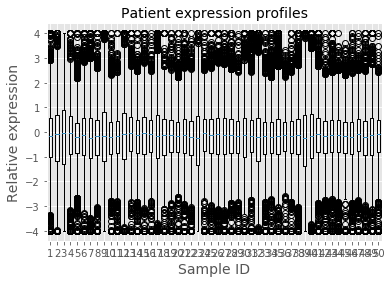

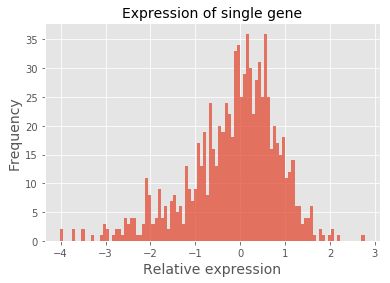

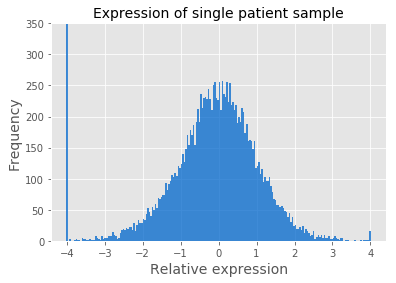

In [33]:
individual_expression_data = [expressionData.iloc[:,i] for i in range(50)]
_ = plt.boxplot(individual_expression_data)
plt.title("Patient expression profiles",FontSize=14)
plt.ylabel("Relative expression",FontSize=14)
plt.xlabel("Sample ID",FontSize=14)
plt.figure()
_ = plt.hist(expressionData.iloc[0,:],bins=100,alpha=0.75)
plt.title("Expression of single gene",FontSize=14)
plt.ylabel("Frequency",FontSize=14)
plt.xlabel("Relative expression",FontSize=14)
plt.figure()
_ = plt.hist(expressionData.iloc[:,0],bins=200,color=[0,0.4,0.8],alpha=0.75)
plt.ylim(0,350)
plt.title("Expression of single patient sample",FontSize=14)
plt.ylabel("Frequency",FontSize=14)
plt.xlabel("Relative expression",FontSize=14)

## Set parameters

In [201]:
# minimum number of genes that form an acceptable coexpression cluster:
minNumberGenes = 6 #bulk RNAseq default=6;single cell RNAseq default=6

# minimum correlation coefficient for an acceptable regulator-cluster association 
minCorrelation = 0.2 #bulk RNAseq default=0.2;single cell RNAseq default=0.05

# minimum number of genes that form an acceptable coexpression cluster and have share binding site for regulator:
minNumberRegulonGenes = 5 #bulk RNAseq default=5;single cell RNAseq default=4

# choose database: if supplying your own database, use mechanistic_database = reference_mechanistic_database
mechanistic_database = "tfbsdb_tf_to_genes.pkl" #default option
#mechanistic_database = reference_mechanistic_database #use if supplying your own database

# number of cores available for multiprocessing
numCores = 5

# 1. Co-expression clustering

0.00 percent complete
20.00 percent complete
40.00 percent complete
60.00 percent complete
80.00 percent complete

coexpression clustering completed in 11.22 minutes
Number of genes clustered: 15002
Number of unique clusters: 1149
Completed clustering module in 12.44 minutes


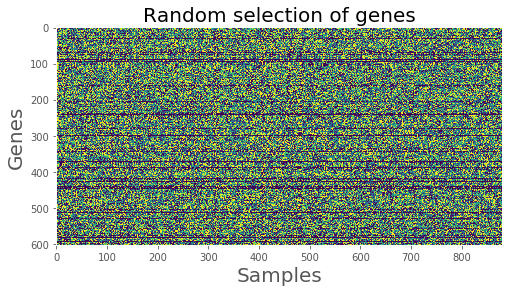

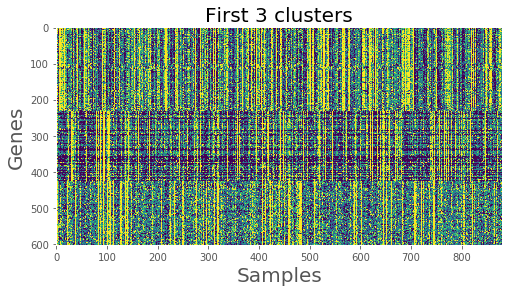

In [376]:
import importlib
importlib.reload(miner)

t1 = time.time()
# generate a list of coexpressed gene clusters, all of which have length >= minNumberGenes
initialClusters = miner.cluster(expressionData,minNumberGenes = minNumberGenes,minNumberOverExpSamples=4,maxSamplesExcluded=0.50,random_state=8,overExpressionThreshold=66.7) 
# revise initialClusters to combine highly correlated clusters and keep only those with significant coexpression
revisedClusters = miner.reviseInitialClusters(initialClusters,expressionData)
# write revisedClusters to .json file
miner.write_json(revisedClusters,os.path.join(resultsDirectory,"coexpressionDictionary.json"))
# ensure that keys have type str

# retrieve first three clusters for visual inspection
first_clusters = np.hstack([revisedClusters[i] for i in np.arange(3).astype(str)])

# visualize background expression
plt.figure(figsize=(8,4))
plt.imshow(expressionData.loc[np.random.choice(expressionData.index,len(first_clusters),replace=False),:],aspect="auto",cmap="viridis",vmin=-1,vmax=1)
plt.grid(False)
plt.ylabel("Genes",FontSize=20)
plt.xlabel("Samples",FontSize=20)
plt.title("Random selection of genes",FontSize=20)

# visualize first 10 clusters
plt.figure(figsize=(8,4))
plt.imshow(expressionData.loc[first_clusters,:],aspect="auto",cmap="viridis",vmin=-1,vmax=1)
plt.grid(False)
plt.ylabel("Genes",FontSize=20)
plt.xlabel("Samples",FontSize=20)
plt.title("First 3 clusters",FontSize=20)

# report coverage
print("Number of genes clustered: {:d}".format(len(set(np.hstack(initialClusters)))))
print("Number of unique clusters: {:d}".format(len(revisedClusters)))

t2 = time.time()
print("Completed clustering module in {:.2f} minutes".format((t2-t1)/60.))

# 2. Mechanistic inference

In [377]:
import importlib
importlib.reload(miner)

t1 = time.time()
# get first principal component axes of clusters
axes = miner.principalDf(revisedClusters,expressionData,subkey=None,minNumberGenes=1)
# analyze revised clusters for enrichment in relational database (default: transcription factor binding site database)
mechanisticOutput = miner.mechanisticInference(axes,revisedClusters,expressionData,correlationThreshold=minCorrelation,numCores=numCores,database=mechanistic_database)
# write mechanistic output to .json file
miner.write_json(mechanisticOutput,os.path.join(resultsDirectory,"mechanisticOutput.json"))
# order mechanisticOutput as {tf:{coexpressionModule:genes}} 
coregulationModules = miner.getCoregulationModules(mechanisticOutput)
# write coregulation modules to .json file
miner.write_json(coregulationModules,os.path.join(resultsDirectory,"coregulationModules.json"))
# get final regulons by keeping genes that requently appear coexpressed and associated to a common regulator
regulons = miner.getRegulons(coregulationModules,minNumberGenes=minNumberRegulonGenes,freqThreshold = 0.333)
# reformat regulon dictionary for consistency with revisedClusters and coexpressionModules
regulonModules, regulonDf = miner.regulonDictionary(regulons)
# write regulonDf to csv using preferred gene name identifiers
regulonDf.to_csv(os.path.join(resultsDirectory,"regulonDf.csv"))
# write regulons to json file
miner.write_json(regulonModules,os.path.join(resultsDirectory,"regulons.json"))
# define coexpression modules as composite of coexpressed regulons
coexpressionModules = miner.getCoexpressionModules(mechanisticOutput)
# write coexpression modules to .json file
miner.write_json(coexpressionModules,os.path.join(resultsDirectory,"coexpressionModules.json"))
# Get eigengenes for all modules
eigengenes = miner.getEigengenes(regulonModules,expressionData,regulon_dict=None,saveFolder=None)
eigenScale = np.percentile(expressionData,95)/np.percentile(eigengenes,95)
eigengenes = eigenScale*eigengenes
eigengenes.index = np.array(eigengenes.index).astype(str)
#write eigengenes to .csv
eigengenes.to_csv(os.path.join(resultsDirectory,"eigengenes.csv"))
#reconvert revised clusters to original gene annotations
# annotatedRevisedClusters = miner.convertDictionary(revisedClusters,conversionTable)
# # write annotated coexpression clusters to .json file
# miner.write_json(revisedClusters,os.path.join(resultsDirectory,"coexpressionDictionary_annotated.json"))
#reconvert results into original annotations
# regulonAnnotatedDf = miner.convertRegulons(regulonDf,conversionTable)
# #write annotated regulon table to .csv
# regulonAnnotatedDf.to_csv(os.path.join(resultsDirectory,"regulons_annotated.csv"))
# #reconvert regulons
# annotatedRegulons = miner.convertDictionary(regulonModules,conversionTable)
# # write annotated regulons to .json file
# miner.write_json(annotatedRegulons,os.path.join(resultsDirectory,"regulons_annotated.json"))
# #reconvert coexpression modules
# annotatedCoexpressionModules = miner.convertDictionary(coexpressionModules,conversionTable)
# # write annotated coexpression modules to .json file
# miner.write_json(annotatedCoexpressionModules,os.path.join(resultsDirectory,"coexpressionModules_annotated.json"))
t2 = time.time()
print("Completed mechanistic inference in {:.2f} minutes".format((t2-t1)/60.))
print("Inferred network with {:d} regulons, {:d} regulators, and {:d} co-regulated genes".format(len(regulonDf.Regulon_ID.unique()),len(regulonDf.Regulator.unique()),len(regulonDf.Gene.unique())))

Running mechanistic inference
Completed mechanistic inference in 4.59 minutes
Inferred network with 3170 regulons, 399 regulators, and 8673 co-regulated genes


In [378]:
ikzf1_upstream_regulons = list(set(regulonDf[regulonDf.Gene==ikzf1]["Regulon_ID"]))
regulonDf_regulon_indexed = regulonDf.copy()
regulonDf_regulon_indexed.index = list(regulonDf.Regulon_ID)
all_selected_genes = list(regulonDf_regulon_indexed.loc[ikzf1_upstream_regulons,"Gene"])
print(len(all_selected_genes))
print(len(set(all_selected_genes)))

96
38


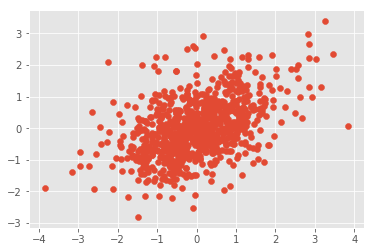

In [379]:
plt.scatter(expressionData.loc[ikzf1,:],eigengenes.loc[ikzf1_upstream_regulons[1],:])

# 3. Causal inference

In [380]:
# Load mutation matrices
common_mutations_file = os.path.join(os.path.split(os.getcwd())[0],"data","mutations","commonMutations.csv")
common_mutations = pd.read_csv(common_mutations_file,index_col=0,header=0)

translocations_file = os.path.join(os.path.split(os.getcwd())[0],"data","mutations","translocationsIA12.csv")
translocations = pd.read_csv(translocations_file,index_col=0,header=0)

cytogenetics_file = os.path.join(os.path.split(os.getcwd())[0],"data","mutations","cytogenetics.csv")
cytogenetics = pd.read_csv(cytogenetics_file,index_col=0,header=0)

In [381]:
# Perform causal analysis for each mutation matrix
mut_matrix = common_mutations.copy()
miner.causalNetworkAnalysis(regulon_matrix=regulonDf.copy(),expression_matrix=expressionData.copy(),reference_matrix=eigengenes.copy(),mutation_matrix=mut_matrix,resultsDirectory=os.path.join(resultsDirectory,"causal_analysis"),minRegulons=1,significance_threshold=0.05,causalFolder="causal_results_common_mutations")

mut_matrix = translocations.copy()
miner.causalNetworkAnalysis(regulon_matrix=regulonDf.copy(),expression_matrix=expressionData.copy(),reference_matrix=eigengenes.copy(),mutation_matrix=mut_matrix,resultsDirectory=os.path.join(resultsDirectory,"causal_analysis"),minRegulons=1,significance_threshold=0.05,causalFolder="causal_results_translocations")

mut_matrix = cytogenetics.copy()
miner.causalNetworkAnalysis(regulon_matrix=regulonDf.copy(),expression_matrix=expressionData.copy(),reference_matrix=eigengenes.copy(),mutation_matrix=mut_matrix,resultsDirectory=os.path.join(resultsDirectory,"causal_analysis"),minRegulons=1,significance_threshold=0.05,causalFolder="causal_results_cytogenetics")

# compile all causal results
causal_directory = os.path.join(resultsDirectory,"causal_analysis")
causal_results = miner.readCausalFiles(causal_directory)
causal_results.to_csv(os.path.join(resultsDirectory,"completeCausalResults.csv"))
causal_results.head()

completed causal analysis in 1.48 minutes
completed causal analysis in 0.25 minutes
completed causal analysis in 0.22 minutes


,Mutation,Regulator,Regulon,MutationRegulatorEdge,-log10(p)_MutationRegulatorEdge,RegulatorRegulon_Spearman_R,RegulatorRegulon_Spearman_p-value,Regulon_stratification_t-statistic,-log10(p)_Regulon_stratification,Fraction_of_edges_correctly_aligned
1299,MYH2,ENSG00000123405,R-1299,-1.0,1.671773,0.543262,8.643329e-69,-2.335435,1.524398,1.0
1302,MYH2,ENSG00000123405,R-1302,-1.0,1.671773,0.496341,5.589942e-56,-2.599307,1.776357,1.0
2444,MYH2,ENSG00000143995,R-2444,-1.0,1.661210,0.155620,3.470864e-06,-2.244326,1.442124,1.0
396,MYH2,ENSG00000113916,R-396,-1.0,1.703597,0.220396,3.742647e-11,-2.839029,2.009937,1.0
3025,MYH2,ENSG00000115415,R-3025,1.0,1.747686,0.214600,1.228638e-10,2.440342,1.629273,1.0


In [382]:
# filtered causal results
causal_results_regulon_filtered = causal_results[causal_results["-log10(p)_Regulon_stratification"]>=-np.log10(0.05)]
causal_results_aligned = causal_results_regulon_filtered[causal_results_regulon_filtered.Fraction_of_edges_correctly_aligned>=0.5]
causal_results_aligned_correlated = causal_results_aligned[causal_results_aligned["RegulatorRegulon_Spearman_p-value"]<=0.05]
causal_results_stratified_aligned_correlated = causal_results_aligned_correlated[causal_results_aligned_correlated["-log10(p)_MutationRegulatorEdge"]>=-np.log10(0.05)]

# for all causal flows, 
# the regulon is differentially active w.r.t the mutation,
# the regulator is differentially active w.r.t the mutation,
# the regulator is significantly correlated to the regulon,
# and the directionality of at least half of the differentially active targets 
# downstream of the regulator are consistent with the perturbation from the mutation

causal_results_stratified_aligned_correlated.to_csv(os.path.join(resultsDirectory,"filteredCausalResults_rs8.csv"))

print(causal_results_regulon_filtered.shape)
print(causal_results_aligned.shape)
print(causal_results_aligned_correlated.shape)
print(causal_results_stratified_aligned_correlated.shape)

(13963, 10)
(13403, 10)
(13298, 10)
(13298, 10)


In [406]:
causal_results_stratified_aligned_correlated[causal_results_stratified_aligned_correlated.Regulator==ikzf1]

,Mutation,Regulator,Regulon,MutationRegulatorEdge,-log10(p)_MutationRegulatorEdge,RegulatorRegulon_Spearman_R,RegulatorRegulon_Spearman_p-value,Regulon_stratification_t-statistic,-log10(p)_Regulon_stratification,Fraction_of_edges_correctly_aligned
2171,XIRP2,ENSG00000185811,R-2171,-1.0,1.749533,-0.205047,8.104255e-10,2.474655,1.649279,1.000000
2166,XIRP2,ENSG00000185811,R-2166,-1.0,1.749533,-0.210653,2.708064e-10,2.263421,1.465112,1.000000
2169,FGFR3,ENSG00000185811,R-2169,1.0,1.588381,0.112347,8.362889e-04,2.232101,1.475307,1.000000
2166,FGFR3,ENSG00000185811,R-2166,1.0,1.588381,-0.210653,2.708064e-10,-2.364042,1.604117,1.000000
2171,IRF4,ENSG00000185811,R-2171,1.0,1.999825,-0.205047,8.104255e-10,-3.748100,2.997707,1.000000
2170,IRF4,ENSG00000185811,R-2170,1.0,1.999825,0.186736,2.350969e-08,2.832092,2.022976,1.000000
2167,IRF4,ENSG00000185811,R-2167,1.0,1.999825,-0.125014,1.992499e-04,-4.474255,3.784570,1.000000
2168,CACNA1H,ENSG00000185811,R-2168,1.0,1.469562,0.314439,1.139044e-21,4.233861,3.389463,1.000000
2166,FAM46C,ENSG00000185811,R-2166,-1.0,1.356575,-0.210653,2.708064e-10,2.849536,2.270724,1.000000
2167,FAM46C,ENSG00000185811,R-2167,-1.0,1.356575,-0.125014,1.992499e-04,4.513829,4.757777,1.000000


# 4. Network mapping

In [383]:
import importlib
importlib.reload(miner)

t1 = time.time()
# select reference dictionary for downstream analysis (revisedClusters, coexpressionModules, or regulonModules)
referenceDictionary = regulonModules
t_tmp1 = time.time()
# create a background matrix used for statistical hypothesis testing
bkgd = miner.backgroundDf(expressionData)
t_tmp2 = time.time()
# for each cluster, give samples that show high coherent cluster activity
overExpressedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=2,p=0.05)
t_tmp3 = time.time()
# for each cluster, give samples that show low coherent cluster activity
underExpressedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=0,p=0.05)
# for each cluster, give samples that do not show coherent cluster activity
# dysregulatedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label="excluded")
# # for each cluster, give samples that show coherent cluster activity, despite magnitude of expression
# coherentMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label="included")

# write membership matrices to .csv file
overExpressedMembersMatrix = miner.membershipToIncidence(overExpressedMembers,expressionData)
overExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"overExpressedMembers.csv"))
underExpressedMembersMatrix = miner.membershipToIncidence(underExpressedMembers,expressionData)
underExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"underExpressedMembers.csv"))
# dysregulatedMembersMatrix = miner.membershipToIncidence(dysregulatedMembers,expressionData)
# dysregulatedMembersMatrix.to_csv(os.path.join(resultsDirectory,"dysregulatedMembers.csv"))
# coherentMembersMatrix = miner.membershipToIncidence(coherentMembers,expressionData)
# coherentMembersMatrix.to_csv(os.path.join(resultsDirectory,"coherentMembers.csv"))

t2 = time.time()
print("Completed patient mapping in {:.2f} minutes".format((t2-t1)/60.))

done!
done!
Completed patient mapping in 1.03 minutes


Text(0.5, 0, 'Samples')

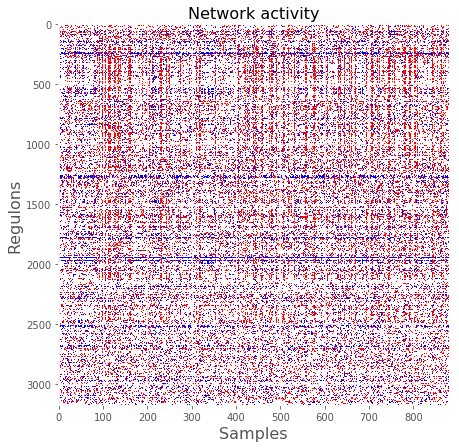

In [384]:
#visualize network activity across individual samples
plt.figure(figsize=(7,7))
network_activity_heatmap = overExpressedMembersMatrix-underExpressedMembersMatrix
plt.imshow(network_activity_heatmap,cmap="bwr",vmin=-1,vmax=1,aspect="auto")
plt.title("Network activity",FontSize=16)
plt.ylabel("Regulons",FontSize=16)
plt.xlabel("Samples",FontSize=16)

# 5. Subtype discovery

In [386]:
importlib.reload(miner)

# Infer transcriptional states
minClusterSize = int(np.ceil(0.01*expressionData.shape[1]))
referenceMatrix = overExpressedMembersMatrix-underExpressedMembersMatrix
primaryMatrix = overExpressedMembersMatrix
primaryDictionary = overExpressedMembers
secondaryMatrix = underExpressedMembersMatrix
secondaryDictionary = underExpressedMembers

states, centroidClusters = miner.inferSubtypes(referenceMatrix,primaryMatrix,secondaryMatrix,primaryDictionary,secondaryDictionary,minClusterSize = int(np.ceil(0.01*expressionData.shape[1])),restricted_index=None)
states_dictionary = {str(i):states[i] for i in range(len(states))}
miner.write_json(states_dictionary,os.path.join(resultsDirectory,"transcriptional_states.json"))

Beginning subtype inference
completed subtype inference in 0.74 minutes


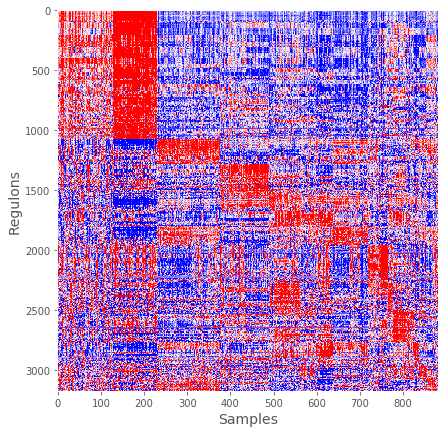

In [387]:
# Infer transcriptional programs
reference_df = eigengenes.copy()
programs, _ = miner.mosaic(dfr=eigengenes.copy(),clusterList=centroidClusters,minClusterSize_x=int(np.ceil(0.01*expressionData.shape[1])),minClusterSize_y=5,allow_singletons=False,max_groups=50,saveFile=os.path.join(resultsDirectory,"regulon_activity_heatmap.pdf"),random_state=12)   
transcriptional_programs, program_regulons = miner.transcriptionalPrograms(programs,referenceDictionary)
program_list = [program_regulons[("").join(["TP",str(i)])] for i in range(len(program_regulons))]
programs_dictionary = {str(i):program_list[i] for i in range(len(program_list))}
miner.write_json(programs_dictionary,os.path.join(resultsDirectory,"transcriptional_programs.json"))
mosaicDf = reference_df.loc[np.hstack(program_list),np.hstack(states)]
mosaicDf.to_csv(os.path.join(resultsDirectory,"regulons_activity_heatmap.csv"))

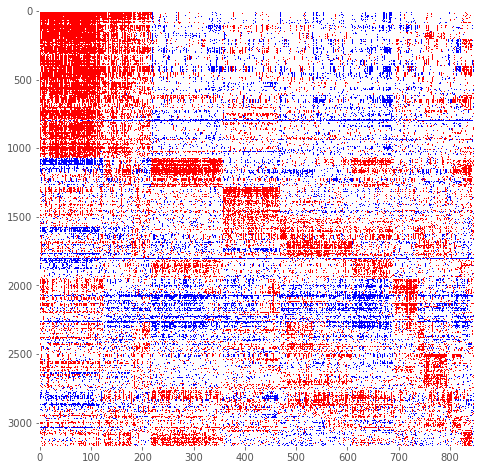

In [388]:
dfr = overExpressedMembersMatrix-underExpressedMembersMatrix
mtrx = dfr.loc[np.hstack(program_list),np.hstack(states)]
plt.figure(figsize=(8,8))
plt.imshow(mtrx,cmap="bwr",vmin=-1,vmax=1,aspect=float(mtrx.shape[1])/float(mtrx.shape[0]))
plt.grid(False)
plt.savefig(os.path.join(resultsDirectory,"mosaic_all.pdf"),bbox_inches="tight")

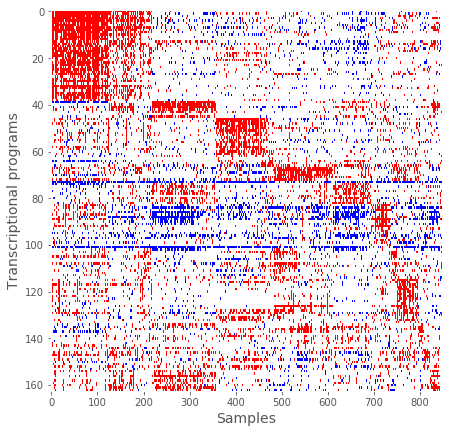

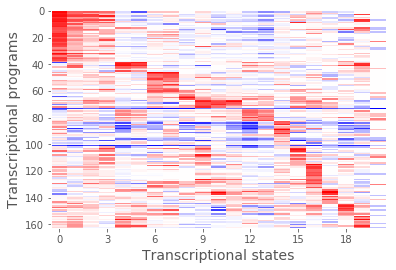

In [389]:
# Determine activity of transcriptional programs in each sample
statesDf = miner.reduceModules(df=dfr.loc[np.hstack(program_list),np.hstack(states)],programs=program_list,states=states,stateThreshold=0.50,saveFile=os.path.join(resultsDirectory,"transcriptional_programs.pdf"))

# Cluster patients into subtypes and give the activity of each program in each subtype
programsVsStates = miner.programsVsStates(statesDf,states,filename=os.path.join(resultsDirectory,"programs_vs_states_predictor.pdf"),showplot=True)

# 6. Risk prediction

## 6a. Risk by subtype

21
10
                              HR       p-value
17&9                    7.757149  8.685960e-15
17&9&10                 7.545834  4.494005e-14
17&9&10&15              7.143047  9.128457e-13
17&9&10&15&14           6.304414  2.892854e-10
17&9&10&15&14&6         4.906309  9.280608e-07
17                      4.512566  6.404813e-06
17&9&10&15&14&6&1       4.343655  1.401315e-05
17&9&10&15&14&6&1&0&11  3.684830  2.288553e-04
17&9&10&15&14&6&1&0     3.474632  5.115538e-04
19&13                  -1.636259  1.017853e-01
19                     -1.992749  4.628894e-02
19&13&4                -3.289775  1.002676e-03
19&13&4&8              -3.741207  1.831384e-04
19&13&4&8&18&16        -3.765202  1.664147e-04
19&13&4&8&18&16&7      -3.785943  1.531270e-04
19&13&4&8&18           -3.819291  1.338357e-04
19&13&4&8&18&16&7&12   -4.109802  3.959979e-05
19&13&4&8&18&16&7&12&5 -4.186174  2.836960e-05
Could not complete Kaplan-Meier analysis and plotting
completed combinatorial transcriptional state s

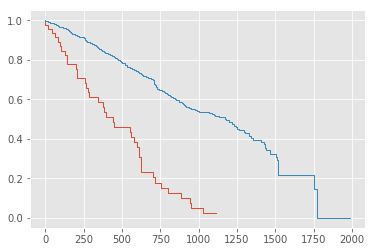

In [390]:
t1 = time.time()

# load survival data
survivalMMRF = pd.read_csv(os.path.join(os.path.split(os.getcwd())[0],"data","survival","survivalIA12.csv"),index_col=0,header=0)
survivalDfMMRF = survivalMMRF.iloc[:,0:2]
survivalDfMMRF.columns = ["duration","observed"]
overExpressedMembersMatrixMMRF = overExpressedMembersMatrix
overExpressedMembersMatrixMMRF = overExpressedMembersMatrixMMRF.loc[np.hstack(program_list),:]

#generate Kaplan-Meier estimates
kmDf = miner.kmAnalysis(survivalDf=survivalDfMMRF,durationCol="duration",statusCol="observed")
#generate GuanRank scores
guanSurvivalDfMMRF = miner.guanRank(kmSurvival=kmDf)

# Visualize risk associated with each transcriptional state

srv = guanSurvivalDfMMRF.copy()
guan_srv = pd.DataFrame(srv.loc[:,"GuanScore"])
guan_srv.columns = ["value"]
guan_srv_group = pd.DataFrame(-np.ones(guan_srv.shape[0]))
guan_srv_group.index = guan_srv.index
guan_srv_group.columns = ["group"]
guan_srv_df = pd.concat([guan_srv,guan_srv_group],axis=1)

states = states
mmrf_groups = [i for i in states if len(set(srv.index)&set(i)) >= 1]
labels = range(len(mmrf_groups))

xmedians = []
for i in range(len(mmrf_groups)):
    group = list(set(srv.index)&set(mmrf_groups[i]))
    if len(group)>=1:
        xmedians.append(np.median(guan_srv_df.loc[group,"value"]))
    elif len(group)<1:
        xmedians.append(0)
    label = labels[i]
    guan_srv_df.loc[group,"group"] = label
print(len(xmedians))

ranked_states = np.argsort(xmedians)

survival_tag = "Risk_groups"

# Combinatorial survival analysis
combined_states, combined_indices = miner.combinedStates(mmrf_groups,ranked_states,srv,minSamples=4,maxStates=10)

state_members = combined_states
sufficient_states = range(len(combined_states))
state_survival = pd.DataFrame(np.zeros((len(state_members),srv.shape[0])))
state_survival.index = sufficient_states
state_survival.columns = srv.index
for ix in range(len(sufficient_states)):
    sm = list(set(state_members[ix])&set(srv.index))
    state_survival.loc[sufficient_states[ix],sm] = 1
    
cox_combined_states = miner.parallelMemberSurvivalAnalysis(membershipDf = state_survival,numCores=1,survivalPath="",survivalData=srv)

cox_hr = [cox_combined_states[i][0] for i in cox_combined_states.keys()]
cox_p = [cox_combined_states[i][1] for i in cox_combined_states.keys()]
cox_combined_states_df = pd.DataFrame(np.vstack([cox_hr,cox_p]).T)
cox_combined_states_df.index = combined_indices
cox_combined_states_df.columns = ["HR","p-value"]
cox_combined_states_df.sort_values(by="HR",ascending=False,inplace=True)
cox_combined_states_df.to_csv(os.path.join(resultsDirectory,"Hazards_regression_of_combined_transcriptional_states.csv"))
print(cox_combined_states_df)

highest_risk_combination = np.array(cox_combined_states_df.index[0].split("&")).astype(int)
lowest_risk_combination = np.array(cox_combined_states_df.index[-1].split("&")).astype(int)

kmTag = "states"
kmFilename = ("_").join([survival_tag,kmTag,".pdf"])
groups = [np.hstack([mmrf_groups[i] for i in highest_risk_combination]),np.hstack([mmrf_groups[i] for i in range(len(mmrf_groups)) if i not in highest_risk_combination])]
labels = np.arange(len(groups)).astype(str)
labels = ["High-risk states","Other states"]
plotName = os.path.join(resultsDirectory,kmFilename)
miner.kmplot(srv=srv,groups=groups,labels=labels,xlim_=(-100,1750),filename=plotName)  

t2 = time.time()
print("completed combinatorial transcriptional state survival analysis in {:.2f} minutes".format((t2-t1)/60.))

Could not complete Kaplan-Meier analysis and plotting
Could not complete Kaplan-Meier analysis and plotting


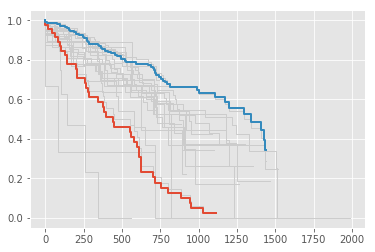

In [392]:
# Visualize survival of selected transcriptional state combinations

select_high = [17,9]
select_low = [4,13,19]
select_small = [i for i in range(len(states)) if len(set(srv.index)&set(states[i])) <= 3]
select_groups = np.hstack([select_high,select_low,select_small])

kmTag = "all_states"
kmFilename = ("_").join([survival_tag,kmTag,".pdf"])
groups = [mmrf_groups[i] for i in range(len(mmrf_groups))]
labels = np.arange(len(groups)).astype(str)
labels = ["State "+str(i) for i in range(len(groups))]
plotName = os.path.join(resultsDirectory,kmFilename)
miner.kmplot(srv=srv,groups=groups,labels=None,xlim_=(-100,1750),filename=None,color=[0.8,0.8,0.8])  

groups = [np.hstack([states[i] for i in select_high]),np.hstack([states[i] for i in select_low])]

labels = np.arange(len(groups)).astype(str)
labels = ["High-risk","Low-risk"]
plotName = os.path.join(resultsDirectory,kmFilename)
miner.kmplot(srv=srv,groups=groups,labels=None,xlim_=(-100,1750),filename=None,lw=2)  
plt.savefig(os.path.join(resultsDirectory,"states_survival_all.pdf"),bbox_inches="tight")


20
completed transcriptional state risk analysis in 0.01 minutes


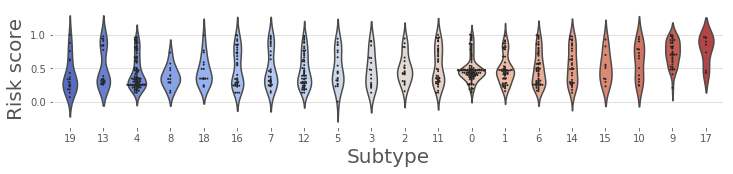

In [393]:
# Plot risk of transcriptional states using normalized GuanRank

t1 = time.time()

mmrf_groups = [states[i] for i in range(len(states)) if len(set(states[i])&set(srv.index)) >=5]
labels = range(len(mmrf_groups))

xmedians = []
for i in range(len(mmrf_groups)):
    group = list(set(srv.index)&set(mmrf_groups[i]))
    if len(group)>=1:
        xmedians.append(np.median(guan_srv_df.loc[group,"value"]))
    elif len(group)<1:
        xmedians.append(0)
    label = labels[i]
    guan_srv_df.loc[group,"group"] = label
print(len(xmedians))

ranked_states = np.argsort(xmedians)

survival_tag = "Risk_groups"
plt.figure(figsize=(12,7))

#my_pal = [(1,1-i/float(len(mmrf_groups)),1-i/float(len(mmrf_groups))) for i in range(len(mmrf_groups))]
ordered_medians = np.array(xmedians)[np.argsort(xmedians)]
my_pal = [(ordered_medians[i],1-ordered_medians[i],1-ordered_medians[i]) for i in range(len(mmrf_groups))]

ax = sns.violinplot(x='group', y='value', data=guan_srv_df,order=ranked_states,inner=None,palette=sns.color_palette("coolwarm", len(mmrf_groups)))#palette=my_pal

ax.set_facecolor([1,1,1])
ax.grid(True,color=[0.85,0.85,0.85])
ax.set_aspect(2)

sns.swarmplot(x='group', y='value',data=guan_srv_df,order=np.argsort(xmedians),size=2, color=[0.15,0.15,0.15],edgecolor="black")
#sns.stripplot(x='group', y='value',data=guan_srv_df,order=np.argsort(xmedians),size=2,color=[0.15,0.15,0.15],edgecolor="black", jitter=False)
    
plt.ylabel("Risk score",FontSize=20)
plt.xlabel("Subtype",FontSize=20)
boxplotFilename = ("_").join([survival_tag,"violinplot_swarm_raw.pdf"])
plt.savefig(os.path.join(resultsDirectory,boxplotFilename),bbox_inches="tight")


t2 = time.time()
print("completed transcriptional state risk analysis in {:.2f} minutes".format((t2-t1)/60.))

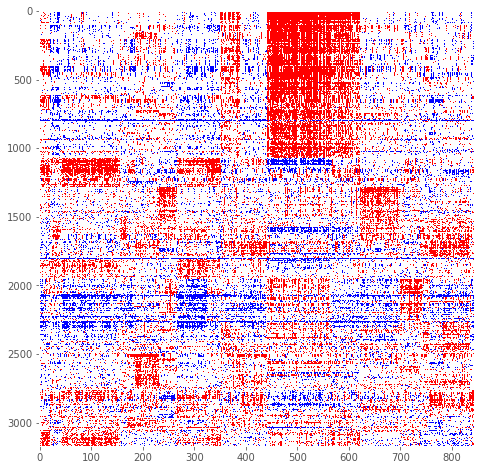

In [394]:
# visualize states ordered states by risk
dfr = overExpressedMembersMatrix-underExpressedMembersMatrix
mtrx = dfr.loc[np.hstack(program_list),np.hstack(np.array(states)[np.argsort(xmedians)])]
plt.figure(figsize=(8,8))
plt.imshow(mtrx,cmap="bwr",vmin=-1,vmax=1,aspect=float(mtrx.shape[1])/float(mtrx.shape[0]))
plt.grid(False)
#plt.savefig(os.path.join(resultsDirectory,"mosaic_all.pdf"),bbox_inches="tight")

In [395]:
# proportional hazards regression of transcriptional programs
cox_programs = miner.parallelMemberSurvivalAnalysis(membershipDf = statesDf,numCores=5,survivalPath="",survivalData=srv)

cox_programs_hr = [cox_programs[i][0] for i in range(len(cox_programs))]
cox_programs_p = [cox_programs[i][1] for i in range(len(cox_programs))]
cox_programs_df = pd.DataFrame(np.vstack([cox_programs_hr,cox_programs_p]).T)
cox_programs_df.index = [list(cox_programs.keys())[i] for i in range(len(cox_programs))]
cox_programs_df.columns = ["HR","p-value"]
cox_programs_df.sort_values(by="HR",ascending=False,inplace=True)
cox_programs_df.to_csv(os.path.join(resultsDirectory,"cox_programs_hrs.csv"))

# filter the transcriptional programs by p-value cutoff
p_cutoff = 1 #p_cutoff = 1 keeps all transcriptional programs for analysis
filtered_cox = cox_programs_df[cox_programs_df["p-value"]<p_cutoff]
filtered_cox.index

# identify positively-labeled patients for each program
program_status = [
    statesDf.columns[np.where(statesDf.loc[p,:]==1)[0]] for p in filtered_cox.index
]

10
10
10
10
10
20
20
20
20
20
30
30
30
30
30


Could not complete Kaplan-Meier analysis and plotting
Could not complete Kaplan-Meier analysis and plotting


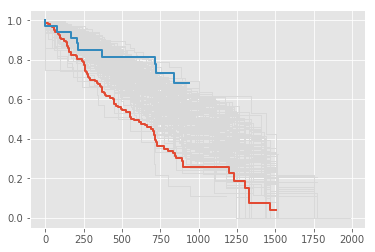

In [396]:
select_high = [0] #highlight high-risk states
select_low = [-1] #highlight low-risk states
select_small = [i for i in range(len(program_status)) if len(set(srv.index)&set(program_status[i])) <= 3]
select_groups = np.hstack([select_high,select_low,select_small])
select_groups = select_small

kmTag = "programs"
kmFilename = ("_").join([survival_tag,kmTag,".pdf"])
groups = [program_status[i] for i in range(len(program_status)) if i not in select_groups]
labels = np.arange(len(groups)).astype(str)
labels = ["State "+str(i) for i in range(len(groups))]
plotName = os.path.join(resultsDirectory,kmFilename)
miner.kmplot(srv=srv,groups=groups,labels=None,xlim_=(-100,1750),filename=None,color=[0.85,0.85,0.85])  

groups = [np.hstack([program_status[i] for i in select_high]),np.hstack([program_status[i] for i in select_low])]

labels = np.arange(len(groups)).astype(str)
labels = ["High-risk","Low-risk"]
plotName = os.path.join(resultsDirectory,kmFilename)
miner.kmplot(srv=srv,groups=groups,labels=None,xlim_=(-100,1750),filename=None,lw=2)  
plt.savefig(os.path.join(resultsDirectory,"programs_survival.pdf"),bbox_inches="tight")


## 6b. Risk by machine-learning classification

## Load expression data

In [331]:
# define modules to interrogate in test sets
reference_modules = regulonModules

# GSE24080UAMS - test set 1
expressionDataGSE24080UAMS = pd.read_csv(os.path.join(os.path.split(os.getcwd())[0],"data","expression","GSE24080UAMSentrezIDlevel.csv"),index_col=0,header=0)
expressionDataGSE24080UAMS, _ = miner.identifierConversion(expressionData=expressionDataGSE24080UAMS)
expressionDataGSE24080UAMS = miner.zscore(expressionDataGSE24080UAMS)
bkgdGSE24080UAMS = miner.backgroundDf(expressionDataGSE24080UAMS)
overExpressedMembersGSE24080UAMS = miner.biclusterMembershipDictionary(reference_modules,bkgdGSE24080UAMS,label=2,p=0.1)
overExpressedMembersMatrixGSE24080UAMS = miner.membershipToIncidence(overExpressedMembersGSE24080UAMS,expressionDataGSE24080UAMS)
underExpressedMembersGSE24080UAMS = miner.biclusterMembershipDictionary(reference_modules,bkgdGSE24080UAMS,label=0,p=0.1)
underExpressedMembersMatrixGSE24080UAMS = miner.membershipToIncidence(underExpressedMembersGSE24080UAMS,expressionDataGSE24080UAMS)

# GSE19784HOVON65 - test set 2
expressionDataGSE19784HOVON65 = pd.read_csv(os.path.join(os.path.split(os.getcwd())[0],"data","expression","GSE19784HOVON65entrezIDlevel.csv"),index_col=0,header=0)
expressionDataGSE19784HOVON65, _ = miner.identifierConversion(expressionData=expressionDataGSE19784HOVON65)
expressionDataGSE19784HOVON65 = miner.zscore(expressionDataGSE19784HOVON65)
bkgdGSE19784HOVON65 = miner.backgroundDf(expressionDataGSE19784HOVON65)
overExpressedMembersGSE19784HOVON65 = miner.biclusterMembershipDictionary(reference_modules,bkgdGSE19784HOVON65,label=2,p=0.1)
overExpressedMembersMatrixGSE19784HOVON65 = miner.membershipToIncidence(overExpressedMembersGSE19784HOVON65,expressionDataGSE19784HOVON65)
underExpressedMembersGSE19784HOVON65 = miner.biclusterMembershipDictionary(reference_modules,bkgdGSE19784HOVON65,label=0,p=0.1)
underExpressedMembersMatrixGSE19784HOVON65 = miner.membershipToIncidence(underExpressedMembersGSE19784HOVON65,expressionDataGSE19784HOVON65)

# EMTAB4032 - test set 3
expressionDataEMTAB4032 = pd.read_csv(os.path.join(os.path.split(os.getcwd())[0],"data","expression","EMTAB4032entrezIDlevel.csv"),index_col=0,header=0)
expressionDataEMTAB4032, _ = miner.identifierConversion(expressionData=expressionDataEMTAB4032)
expressionDataEMTAB4032 = miner.zscore(expressionDataEMTAB4032)
bkgdEMTAB4032 = miner.backgroundDf(expressionDataEMTAB4032)
overExpressedMembersEMTAB4032 = miner.biclusterMembershipDictionary(reference_modules,bkgdEMTAB4032,label=2,p=0.1)
overExpressedMembersMatrixEMTAB4032 = miner.membershipToIncidence(overExpressedMembersEMTAB4032,expressionDataEMTAB4032)
underExpressedMembersEMTAB4032 = miner.biclusterMembershipDictionary(reference_modules,bkgdEMTAB4032,label=0,p=0.1)
underExpressedMembersMatrixEMTAB4032 = miner.membershipToIncidence(underExpressedMembersEMTAB4032,expressionDataEMTAB4032)

# generate discrete network mapping matrices for each dataset
dfr = overExpressedMembersMatrix-underExpressedMembersMatrix
dfrGSE24080UAMS = overExpressedMembersMatrixGSE24080UAMS-underExpressedMembersMatrixGSE24080UAMS
dfrGSE19784HOVON65 = overExpressedMembersMatrixGSE19784HOVON65-underExpressedMembersMatrixGSE19784HOVON65
dfrEMTAB4032 = overExpressedMembersMatrixEMTAB4032-underExpressedMembersMatrixEMTAB4032

completed identifier conversion.
16998 genes were converted.
completed z-transformation.
done!
done!
completed identifier conversion.
16998 genes were converted.
completed z-transformation.
done!
done!
completed identifier conversion.
17228 genes were converted.
completed z-transformation.
done!
done!


## Load survival data

In [332]:
survival = pd.read_csv(os.path.join(os.path.split(os.getcwd())[0],"data","survival","globalClinTraining.csv"),index_col=0,header=0)

# GSE24080UAMS
survivalGSE24080UAMS = survival[survival.index=='GSE24080UAMS']
survivalGSE24080UAMS.index = survivalGSE24080UAMS.iloc[:,0]
survivalDfGSE24080UAMS = survivalGSE24080UAMS.loc[:,["D_PFS","D_PFS_FLAG"]]
survivalDfGSE24080UAMS.columns = ["duration","observed"]
kmDfGSE24080UAMS = miner.kmAnalysis(survivalDf=survivalDfGSE24080UAMS,durationCol="duration",statusCol="observed")
guanSurvivalDfGSE24080UAMS = miner.guanRank(kmSurvival=kmDfGSE24080UAMS)

# GSE19784HOVON65 
survivalGSE19784HOVON65 = survival[survival.index=='HOVON65']
survivalGSE19784HOVON65.index = survivalGSE19784HOVON65.iloc[:,0]
survivalDfGSE19784HOVON65 = survivalGSE19784HOVON65.loc[:,["D_PFS","D_PFS_FLAG"]]
survivalDfGSE19784HOVON65.columns = ["duration","observed"]
kmDfGSE19784HOVON65 = miner.kmAnalysis(survivalDf=survivalDfGSE19784HOVON65,durationCol="duration",statusCol="observed")
guanSurvivalDfGSE19784HOVON65 = miner.guanRank(kmSurvival=kmDfGSE19784HOVON65)

# EMTAB4032
survivalEMTAB4032 = survival[survival.index=='EMTAB4032']
survivalEMTAB4032.index = survivalEMTAB4032.iloc[:,0]
survivalDfEMTAB4032 = survivalEMTAB4032.loc[:,["D_PFS","D_PFS_FLAG"]]
survivalDfEMTAB4032.columns = ["duration","observed"]
kmDfEMTAB4032 = miner.kmAnalysis(survivalDf=survivalDfEMTAB4032,durationCol="duration",statusCol="observed")
guanSurvivalDfEMTAB4032 = miner.guanRank(kmSurvival=kmDfEMTAB4032)

# load primary survival data (i.e., corresponding to expression data training set)
survivalMMRF = pd.read_csv(os.path.join(os.path.split(os.getcwd())[0],"data","survival","survivalIA12.csv"),index_col=0,header=0)
survivalDfMMRF = survivalMMRF.iloc[:,0:2]
survivalDfMMRF.columns = ["duration","observed"]
overExpressedMembersMatrixMMRF = overExpressedMembersMatrix
kmDfMMRF = miner.kmAnalysis(survivalDf=survivalDfMMRF,durationCol="duration",statusCol="observed")
guanSurvivalDfMMRF= miner.guanRank(kmSurvival=kmDfMMRF)

## Generate predictor

(16, 0.7526573861909034, 5.684165673278644)
classified 11.9 percent of training population as high-risk
classified 9.1 percent of test population as high-risk
16


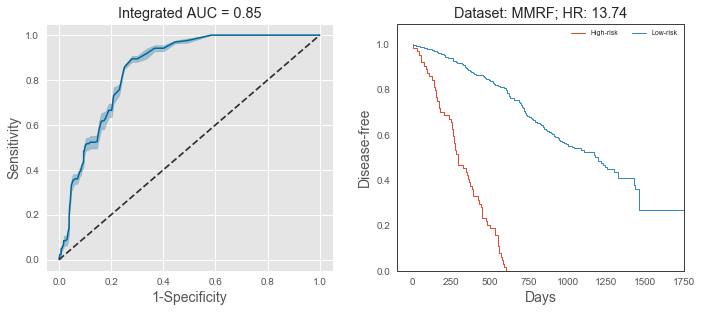

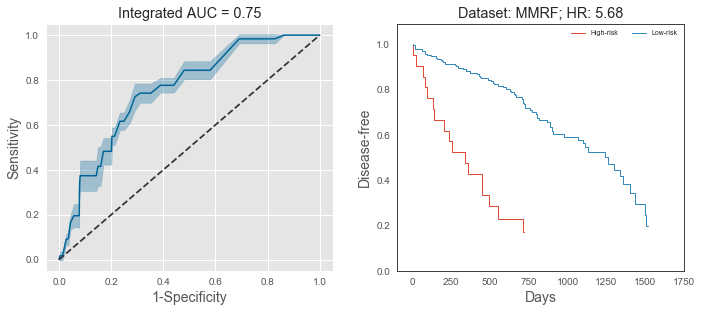

In [1961]:
reload(miner)

membership_datasets = [
    overExpressedMembersMatrix
]

survival_datasets = [
    guanSurvivalDfMMRF
]

dataset_labels = [
    "MMRF"
]


#iterations = 30,method='xgboost',output_directory=resultsDirectory,metric='hazard_ratio',separate_results=True,best_state=13,n_estimators=100,class1_proportion=0.30,test_proportion=0.35
#classifier, class_0, class_1 = miner.generatePredictor(membership_datasets,survival_datasets,dataset_labels,iterations = 30,method='xgboost',output_directory=resultsDirectory,metric='hazard_ratio',separate_results=True,n_estimators=100,class1_proportion=0.25,best_state=24,test_proportion=0.35)

# best MMRF: classifier, class_0, class_1 = miner.generatePredictor(membership_datasets,survival_datasets,dataset_labels,iterations = 30,method='xgboost',output_directory=resultsDirectory,metric='hazard_ratio',separate_results=True,n_estimators=100,class1_proportion=0.25,test_proportion=0.3,best_state=12)
# best GSE24080UAMS: classifier, class_0, class_1 = miner.generatePredictor(membership_datasets,survival_datasets,dataset_labels,iterations = 30,method='xgboost',output_directory=resultsDirectory,metric='roc_auc',separate_results=True,n_estimators=100,class1_proportion=0.25,test_proportion=0.25,best_state=27)
# best GSE19784HOVON65: classifier, class_0, class_1 = miner.generatePredictor(membership_datasets,survival_datasets,dataset_labels,iterations = 30,method='xgboost',output_directory=resultsDirectory,metric='roc_auc',separate_results=True,n_estimators=100,class1_proportion=0.30,test_proportion=0.25,best_state=3)
# best EMTAB4032: classifier, class_0, class_1 = miner.generatePredictor(membership_datasets,survival_datasets,dataset_labels,iterations = 30,method='xgboost',output_directory=resultsDirectory,metric='roc_auc',separate_results=True,n_estimators=50,class1_proportion=0.30,test_proportion=0.25,best_state=24)

classifier, class0, class1, mean_aucs, mean_hrs, pct_labeled = miner.generatePredictor(membership_datasets,survival_datasets,dataset_labels,iterations = 30,method='xgboost',output_directory=resultsDirectory,metric='hazard_ratio',separate_results=True,n_estimators=100,class1_proportion=0.25,test_proportion=0.30,best_state=16)

## Evaluate classifications in each separate dataset

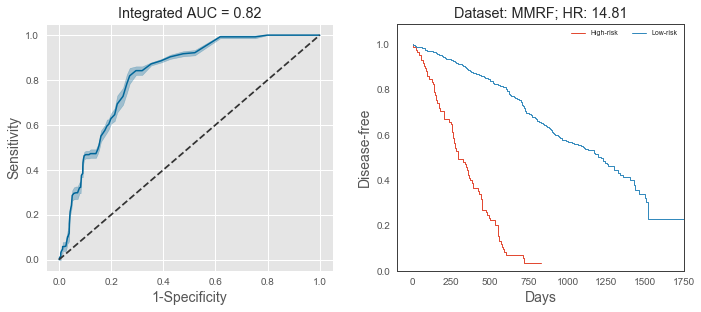

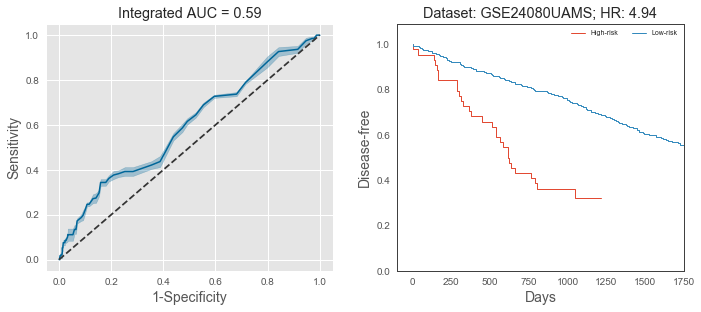

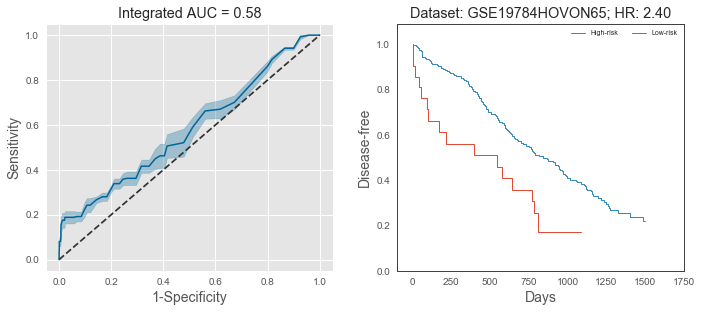

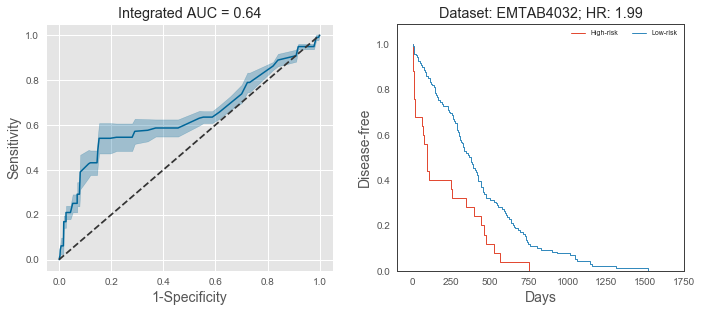

In [1962]:
membership_datasets = [
    overExpressedMembersMatrix,
    overExpressedMembersMatrixGSE24080UAMS,
    overExpressedMembersMatrixGSE19784HOVON65,
    overExpressedMembersMatrixEMTAB4032
]

survival_datasets = [
    guanSurvivalDfMMRF,
    guanSurvivalDfGSE24080UAMS,
    guanSurvivalDfGSE19784HOVON65,
    guanSurvivalDfEMTAB4032
]

dataset_labels = [
    "MMRF",
    "GSE24080UAMS",
    "GSE19784HOVON65",
    "EMTAB4032"
]

predictions = []
for p in range(len(membership_datasets)):
    tmp_predictions = classifier.predict(np.array(membership_datasets[p].T))
    predictions.append(tmp_predictions)

for j in range(len(membership_datasets)):
    mtrx = membership_datasets[j]
    guan_srv = survival_datasets[j]
    survival_tag = dataset_labels[j]
    lbls = predictions[j]
    aucs, cutoffs, tpr_list, fpr_list, hazard_ratio = miner.riskStratification(lbls,mtrx,guan_srv,survival_tag,classifier,guan_rank=False,resultsDirectory=None,plot_all=False,plot_any=True)


## Determine percent predicted high-risk

In [1964]:
# generate predictions for each dataset
reload(miner)
predictor_tag = "IA12"
mmrfIA12_predictions = classifier.predict(np.array(overExpressedMembersMatrix.T))
GSE24080UAMS_predictions = classifier.predict(np.array(overExpressedMembersMatrixGSE24080UAMS.T))
GSE19784HOVON65_predictions = classifier.predict(np.array(overExpressedMembersMatrixGSE19784HOVON65.T))
EMTAB4032_predictions = classifier.predict(np.array(overExpressedMembersMatrixEMTAB4032.T))

percent_classified_hr = 100*sum(mmrfIA12_predictions)/float(len(mmrfIA12_predictions))
print('classified {:.1f} percent of population as high-risk'.format(percent_classified_hr))
percent_classified_hr = 100*sum(GSE24080UAMS_predictions)/float(len(GSE24080UAMS_predictions))
print('classified {:.1f} percent of population as high-risk'.format(percent_classified_hr))
percent_classified_hr = 100*sum(GSE19784HOVON65_predictions)/float(len(GSE19784HOVON65_predictions))
print('classified {:.1f} percent of population as high-risk'.format(percent_classified_hr))
percent_classified_hr = 100*sum(EMTAB4032_predictions)/float(len(EMTAB4032_predictions))
print('classified {:.1f} percent of population as high-risk'.format(percent_classified_hr))

classified 14.1 percent of population as high-risk
classified 7.9 percent of population as high-risk
classified 7.8 percent of population as high-risk
classified 17.0 percent of population as high-risk


## Visualize decision-tree (decision-tree classifier)

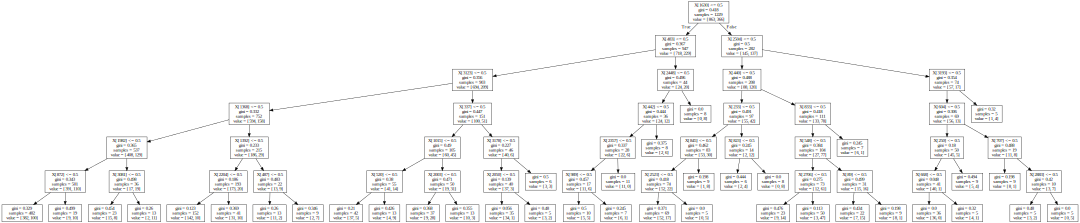

In [1891]:
from sklearn import tree
from sklearn.externals.six import StringIO  
import pydot 
from graphviz import Source

dot_data = StringIO() 
tree.export_graphviz(classifier, out_file=dot_data) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
#graph[0].write_pdf(os.path.join(resultsDirectory,"decisionTreeAUC.pdf"))

# visualize decision tree
graph[0].set_graph_defaults(size = "\"15,15\"")
decisionTree = Source(graph[0].to_string())
decisionTree

## Visualize decision-tree (XGBoost classifier)

In [ ]:
plot_tree(classifier, num_trees=1)
fig = plt.gcf()
fig.set_size_inches(50, 10)
# plt.savefig(os.path.join(resultsDirectory,"xgboost_tree_0.pdf"))

## Save predictor

In [362]:
# save the model to disk
filename = os.path.join(resultsDirectory,'miner_xgboost_predictor_hr.pkl')
pickle.dump(classifier, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.8861788617886179


## Investigate feature importance

In [1965]:
# Quantify importance of individual features
rank = 1 # 1 is the most important feature, -1 is the least important non-zero feature
fi = np.array(classifier.feature_importances_)
feature = overExpressedMembersMatrix.index[np.argsort(fi)[-rank]]
print(feature,fi[np.argsort(fi)[-rank]])

('961', 0.048275862)


In [1966]:
# Tabulate important features into dataframe
fi_df = pd.DataFrame(fi)
fi_df.index = overExpressedMembersMatrix.index
fi_df.columns = ["feature_importance"]
fi_df_filtered = fi_df[fi_df["feature_importance"]>0]
fi_df_filtered.index

Index([u'26', u'27', u'55', u'108', u'116', u'159', u'192', u'201', u'224',
       u'246', u'251', u'257', u'331', u'355', u'367', u'398', u'494', u'542',
       u'597', u'625', u'634', u'678', u'711', u'754', u'911', u'961', u'994',
       u'1110', u'1126', u'1155', u'1164', u'1206', u'1242', u'1267', u'1380',
       u'1426', u'1433', u'1472', u'1529', u'1541', u'1553', u'1579', u'1612',
       u'1622', u'1627', u'1633', u'1738', u'1743', u'1750', u'1753', u'1771',
       u'1785', u'1789', u'1795', u'1926', u'1954', u'2045', u'2093', u'2107',
       u'2120', u'2163', u'2164', u'2193', u'2253', u'2273', u'2281', u'2317',
       u'2361', u'2379', u'2427', u'2468', u'2559', u'2666', u'2722', u'2729',
       u'2758', u'2771', u'2820', u'2823', u'2972', u'2997', u'2998', u'3003',
       u'3049', u'3057', u'3105', u'3117', u'3155'],
      dtype='object')

In [1967]:
# List number of times individual genes and regulators appear in important features

allgenes = []
allregulators = []
for reg_id in list(fi_df_filtered.index):
    genes = list(regulonDf_indexed.loc[reg_id,"Gene"])
    regulator = list(regulonDf_indexed.loc[reg_id,"Regulator"])[0]
    allgenes.append(genes)
    allregulators.append(regulator)
    
count_genes = Counter(np.hstack(allgenes))
count_regulators = Counter(allregulators)

genes_mc = count_genes.most_common()
regulators_mc = count_regulators.most_common()
print(genes_mc[0:10],regulators_mc[0:10])

([('ENSG00000113810', 3), ('ENSG00000002919', 3), ('ENSG00000138668', 3), ('ENSG00000274665', 3), ('ENSG00000056277', 3), ('ENSG00000281540', 3), ('ENSG00000144579', 3), ('ENSG00000012048', 3), ('ENSG00000166483', 3), ('ENSG00000103522', 3)], [('ENSG00000196628', 3), ('ENSG00000185591', 2), ('ENSG00000126561', 2), ('ENSG00000184481', 2), ('ENSG00000204103', 2), ('ENSG00000112658', 2), ('ENSG00000126456', 2), ('ENSG00000065970', 2), ('ENSG00000069667', 2), ('ENSG00000131408', 2)])


In [1968]:
# Convert ensembl gene identifiers to gene symbols for quick reference
# requires installation of "mygene"

conv_ = [i[0] for i in genes_mc[0:20]]
#conv_ = [i[0] for i in regulators_mc[0:20]]
#conv_ = list(regulonDf[regulonDf.Regulon_ID==1366]["Gene"])
geneset = miner.gene_conversion(conv_,list_symbols=True)
np.savetxt(os.path.join(resultsDirectory,"geneset.txt"),geneset,fmt="%1.50s")
print(geneset)

querying 1-20...done.
Finished.
[u'TCF4', u'SP1', u'STAT5A', u'FOXO4', u'MAFB', u'SRF', u'IRF3', u'FOXJ2', u'RORA', u'NR1H2', u'IRF1', u'STAT6', u'THRB', u'IRF9', u'CDC5L', u'PBX1', u'NKX3-1', u'FOXK1', u'ZKSCAN3', u'ARID5A']


In [1969]:
# print number of features with non-zero predictive importance
len(important_regulons)

385

# 7. Perform differential network analysis

In [333]:
# Define phenotypes of interest
all_patients = expressionData.columns
baseline_patients = [pat for pat in all_patients if pat.split("_")[2]=='1']
first_relapse_patients = [pat for pat in all_patients if pat.split("_")[2]=='2']
relapse_patients = [pat for pat in all_patients if pat.split("_")[2]!='1']
multiple_relapse_patients = list(set(relapse_patients)-set(first_relapse_patients))

phenotype1 = baseline_patients
phenotype2 = relapse_patients

Text(0, 0.5, 'Relative expression')

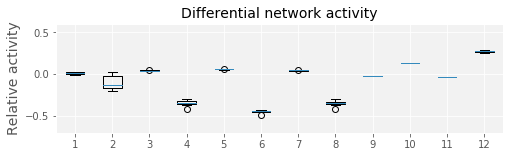

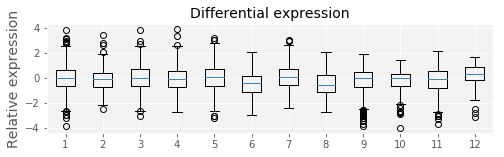

In [397]:
ikzf1 = "ENSG00000185811"
ikzf3 = "ENSG00000161405"
crbn = "ENSG00000113851"
nr3c1 = "ENSG00000113580"
psmb1 = "ENSG00000008018"
psmb5 = "ENSG00000100804"
genelist = [ikzf1,ikzf3,crbn,nr3c1,psmb1,psmb5]

boxplot_data = []
expression_data = []
for gene in genelist:

    regulons_ = [key for key in regulonModules.keys() if gene in regulonModules[key]]
    #regulons_ = np.array(list(set(regulonDf[regulonDf.Regulator==gene]["Regulon_ID"]))).astype(str)

    reference_matrix = eigengenes.copy()

    baseline_regulons = []
    first_relapse_regulons = []
    multiple_relapse_regulons = []
    relapse_regulons = []
    
    for regulon_ in regulons_:
        r, p = stats.spearmanr(expressionData.loc[gene,reference_matrix.columns],reference_matrix.loc[regulon_,:])
        edge_direction = r/np.abs(float(r))
        #edge_direction = 1
        #baseline_values = np.mean(np.mean(expressionData.loc[regulonModules[regulon_],baseline_patients],axis=0))
        #relapse_values = np.mean(np.mean(expressionData.loc[regulonModules[regulon_],relapse_patients],axis=0))
        baseline_values = edge_direction*np.mean(reference_matrix.loc[regulon_,phenotype1])
        baseline_regulons.append(baseline_values)
        relapse_values = edge_direction*np.mean(reference_matrix.loc[regulon_,phenotype2])
        relapse_regulons.append(relapse_values)    
        #print(relapse_values)
    boxplot_data.append(baseline_regulons)
    boxplot_data.append(relapse_regulons)
    expression_data.append(expressionData.loc[gene,phenotype1])
    expression_data.append(expressionData.loc[gene,phenotype2])

fig = plt.figure(figsize=(8,2))
ax = fig.add_subplot(111)
ax.set_facecolor([0.95,0.95,0.95])

plt.boxplot(boxplot_data)
plt.ylim(-0.7,0.6)
plt.title("Differential network activity",FontSize = 14)
plt.ylabel("Relative activity",FontSize = 14)
#plt.savefig(os.path.join(resultsDirectory,"differential_activity_"+(";").join(genelist)+".pdf"),bbox_inches="tight")

fig = plt.figure(figsize=(8,2))
ax = fig.add_subplot(111)
ax.set_facecolor([0.95,0.95,0.95])
plt.boxplot(expression_data)
plt.title("Differential expression",FontSize = 14)
plt.ylabel("Relative expression",FontSize = 14)
#plt.savefig(os.path.join(resultsDirectory,"differential_expression_"+(";").join(genelist)+".pdf"),bbox_inches="tight")

Text(0.5,0,u'Overexpression frequency at relapse')

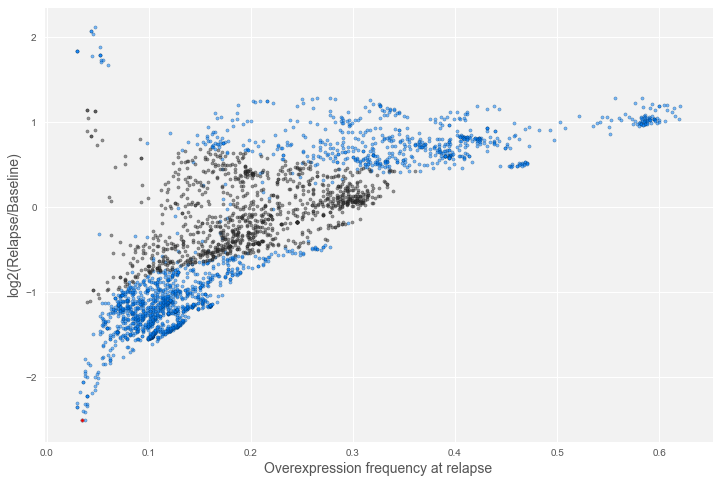

In [78]:
#Visualize differential network activity
reload(miner)
targets = [ikzf1,ikzf3,crbn,nr3c1,psmb1,psmb5]
volcano_data_5 = miner.differentialActivity(regulon_matrix = regulonDf.copy(),reference_matrix = overExpressedMembersMatrix.copy(),baseline_patients=phenotype1,relapse_patients=phenotype2,maxRegulons = 5,minRegulons = 5,useAllRegulons = False,highlight = targets,savefile = os.path.join(resultsDirectory,"baseline_vs_relapse_top3regulons.pdf"))
volcano_data_ = volcano_data_5.copy()

insigvoldata_patients = volcano_data_.index[volcano_data_["-log10(p)"]<=-np.log10(0.05)]
sigvoldata_patients = volcano_data_.index[volcano_data_["-log10(p)"]>-np.log10(0.05)]

insigvoldata = volcano_data_.loc[insigvoldata_patients,:]
sigvoldata = volcano_data_.loc[sigvoldata_patients,:]

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.set_facecolor([0.95,0.95,0.95])
#ax.grid(color=[0.9,0.9,0.9])
ax.scatter(sigvoldata["phenotype2_frequency"],np.array(sigvoldata["log2(phenotype2/phenotype1)"]),color = [0,0.5,1],edgecolor = [0,0.2,0.4],alpha=0.5,s=10)
ax.scatter(insigvoldata["phenotype2_frequency"],np.array(insigvoldata["log2(phenotype2/phenotype1)"]),color = [0.2,0.2,0.2],edgecolor = [0.1,0.1,0.1],alpha=0.5,s=10)
ax.scatter(volcano_data_.loc[ikzf1,"phenotype2_frequency"],np.array(volcano_data_.loc[ikzf1,"log2(phenotype2/phenotype1)"]),color = [0.9,0.0,0.0],edgecolor=[0.8,0.4,0.4],s=10)
#ax.scatter(volcano_data_.loc[phf19,"phenotype2_frequency"],np.array(volcano_data_.loc[phf19,"log2(phenotype2/phenotype1)"]),color = "red",edgecolor="blue",s=5)

#plt.ylim(-2.8,2.4)
plt.ylabel("log2(Relapse/Baseline)",FontSize=14)
plt.xlabel("Overexpression frequency at relapse",FontSize=14)
#plt.savefig(os.path.join(resultsDirectory,"differential_network_volcano.pdf"),bbox_inches="tight")

In [60]:
sigvoldata.to_csv(os.path.join(resultsDirectory,"volcanoPlot_data_5_regulons.csv"))

/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


completed in 1.96 minutes


Text(0.5, 0, 'Overexpression frequency at relapse')

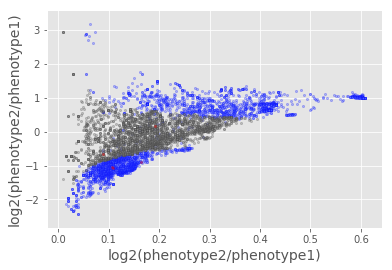

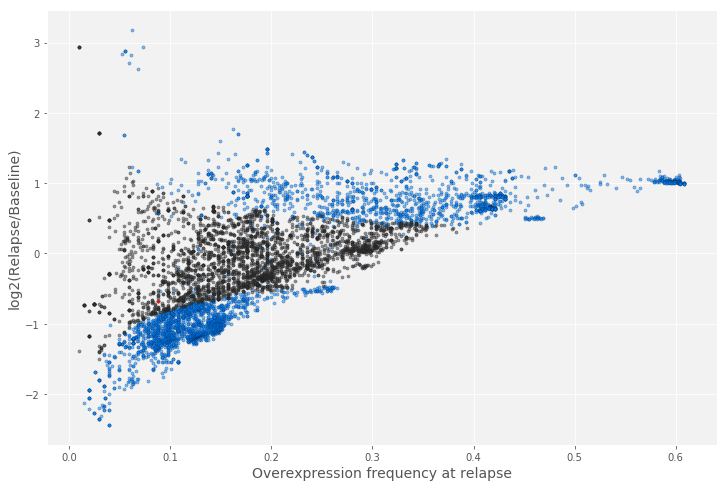

In [398]:
#Visualize differential network activity

targets = [ikzf1,ikzf3,crbn,nr3c1,psmb1,psmb5]
volcano_data_all = miner.differentialActivity(regulon_matrix = regulonDf.copy(),reference_matrix = overExpressedMembersMatrix.copy(),baseline_patients=phenotype1,relapse_patients=phenotype2,maxRegulons = 10,minRegulons = 2,useAllRegulons = True,highlight = targets,savefile = os.path.join(resultsDirectory,"baseline_vs_relapse_atLeast2regulons.pdf"))
volcano_data_ = volcano_data_all.copy()

insigvoldata_patients = volcano_data_.index[volcano_data_["-log10(p)"]<=-np.log10(0.05)]
sigvoldata_patients = volcano_data_.index[volcano_data_["-log10(p)"]>-np.log10(0.05)]

insigvoldata = volcano_data_.loc[insigvoldata_patients,:]
sigvoldata = volcano_data_.loc[sigvoldata_patients,:]

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.set_facecolor([0.95,0.95,0.95])
#ax.grid(color=[0.9,0.9,0.9])
ax.scatter(sigvoldata["phenotype2_frequency"],np.array(sigvoldata["log2(phenotype2/phenotype1)"]),color = [0,0.5,1],edgecolor = [0,0.2,0.4],alpha=0.5,s=10)
ax.scatter(insigvoldata["phenotype2_frequency"],np.array(insigvoldata["log2(phenotype2/phenotype1)"]),color = [0.2,0.2,0.2],edgecolor = [0.1,0.1,0.1],alpha=0.5,s=10)
ax.scatter(volcano_data_.loc[ikzf1,"phenotype2_frequency"],np.array(volcano_data_.loc[ikzf1,"log2(phenotype2/phenotype1)"]),color = [0.9,0.0,0.0],edgecolor=[0.8,0.4,0.4],s=10)
#ax.scatter(volcano_data_.loc[phf19,"phenotype2_frequency"],np.array(volcano_data_.loc[phf19,"log2(phenotype2/phenotype1)"]),color = "red",edgecolor="blue",s=5)

#plt.ylim(-2.8,2.4)
plt.ylabel("log2(Relapse/Baseline)",FontSize=14)
plt.xlabel("Overexpression frequency at relapse",FontSize=14)
#plt.savefig(os.path.join(resultsDirectory,"differential_network_volcano.pdf"),bbox_inches="tight")

In [399]:
sigvoldata.to_csv(os.path.join(resultsDirectory,"volcanoPlot_data_all_regulons_min2.csv"))

In [400]:
symbol_index_df = miner.gene_conversion(sigvoldata.index)
symbol_index_df.head()

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-3187...done.
Finished.
1 input query terms found no hit:
	['ENSG00000168078']
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


,_id,_score,notfound,symbol
query,,,,
ENSG00000166851,5347,18.984797,NaN,PLK1
ENSG00000162062,80178,20.206417,NaN,TEDC2
ENSG00000129810,151648,18.948820,NaN,SGO1
ENSG00000143815,3930,18.339300,NaN,LBR
ENSG00000073111,4171,19.241930,NaN,MCM2


In [401]:
symbol_index_df = symbol_index_df[symbol_index_df.notnull()]
sigvoldata = sigvoldata.loc[symbol_index_df.index,:]
all_regulons_volcano_ascending = sigvoldata.copy()
all_regulons_volcano_ascending.index = list(symbol_index_df['symbol'])
all_regulons_volcano_ascending.sort_values(by=['-log10(p)','log2(phenotype2/phenotype1)'],ascending=[False,True],inplace=True)
all_regulons_volcano_ascending.head(10)

,phenotype1_frequency,phenotype2_frequency,log2(phenotype2/phenotype1),-log10(p)
PLK1,0.258023,0.583333,1.176820,11.131434
TEDC2,0.278562,0.602941,1.114017,10.537678
SGO1,0.282413,0.602941,1.094209,10.285914
LBR,0.273000,0.588235,1.107495,10.258907
MCM2,0.283376,0.600490,1.083422,10.014240
CCNF,0.271887,0.584314,1.103736,10.012925
HJURP,0.287120,0.604575,1.074267,10.006958
E2F8,0.277065,0.586601,1.082158,9.763079
PCNA,0.277065,0.586601,1.082158,9.763079
FOXM1,0.287227,0.600490,1.063948,9.758893


In [402]:
tmp1 = all_regulons_volcano_ascending[all_regulons_volcano_ascending["log2(phenotype2/phenotype1)"]<-2]
tmp2 = tmp1 #tmp1[tmp1.phenotype2_frequency<0.48]
geneset = tmp2.index

In [403]:
#geneset = all_regulons_volcano_ascending.index[0:50]
np.savetxt(os.path.join(resultsDirectory,"geneset.txt"),geneset,fmt="%1.50s")

In [356]:
all_regulons_volcano_ascending.loc["PHF19",:]

phenotype1_frequency           0.289153
phenotype2_frequency           0.587010
log2(phenotype2/phenotype1)    1.021553
-log10(p)                      8.843562
Name: PHF19, dtype: float64

# 8. Visualize with tSNE

completed tsne visualization in 0.13 minutes


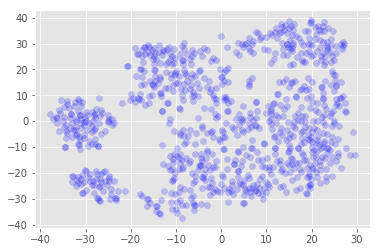

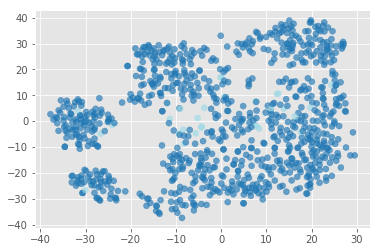

In [347]:
t1 = time.time()

# tSNE applied to expressionData. Set plotOnly = False to return tSNE coordinates
# consider changing the perplexity to explore different degrees of cluster separation
# miner.tsne(expressionData,perplexity=15,n_components=2,n_iter=1000,plotOnly=True,plotColor="red",alpha=0.4)
# plt.savefig(os.path.join(resultsDirectory,"tsne_gene_expression.pdf"),bbox_inches="tight")

# tSNE applied to df_for_tsne. Consider changing the perplexity in the range of 5 to 50
df_for_tsne = eigengenes.copy()
plt.figure()
X_embedded = miner.tsne(df_for_tsne,perplexity=30,n_components=2,n_iter=1000,plotOnly=None,plotColor="blue",alpha=0.2)
tsneDf = pd.DataFrame(X_embedded)
tsneDf.index = df_for_tsne.columns
tsneDf.columns = ["tsne1","tsne2"]
plt.savefig(os.path.join(resultsDirectory,"tsne_regulon_activity.pdf"),bbox_inches="tight")

# convert states to tsne labels

state_labels = miner.tsneStateLabels(tsneDf,states)

# overlay states cluster labels
plt.figure()
plt.scatter(tsneDf.iloc[:,0],tsneDf.iloc[:,1],cmap="tab20",c=state_labels,alpha=0.65)
plt.savefig(os.path.join(resultsDirectory,"labeled_tsne_states.pdf"),bbox_inches="tight")

# overlay activity of transcriptional programs
#miner.plotStates(statesDf,tsneDf,numCols=int(np.sqrt(statesDf.shape[0])),saveFile = os.path.join(resultsDirectory,("_").join(["states_regulons",("").join(["0o",str(minCorrelation).split(".")[1]]),"tsne.pdf"])),aspect=1,size=10,scale=3)

t2 = time.time()
print("completed tsne visualization in {:.2f} minutes".format((t2-t1)/60.))
